In [1]:
import numpy as np 
import torch 
import torch.nn as nn
from skimage.data import shepp_logan_phantom
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from skimage.transform import resize, radon, iradon

In [2]:
#Setup 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
nxd = 182
theta = np.linspace(0., 180., max(nxd, 180), endpoint=False)

In [28]:
#Reading in CT scan Data 
import nibabel as nib

img = nib.load("LondonPride_000101_dynPET.img")
pet_data = img.get_fdata() 

print(pet_data.shape)

# Get full Z range and calculate start and end
total_slices = pet_data.shape[2]
center = total_slices // 2
half_window = 30
z_start = center - half_window
z_end = center + half_window

# Just to be safe:
z_start = max(0, z_start)
z_end = min(total_slices, z_end)

print(z_start, z_end)

# Get full t range and calculate start and end
total_slices = pet_data.shape[3]
center = total_slices // 2
half_window = 5
t_start = center - half_window
t_end = center + half_window

# Just to be safe:
t_start = max(0, t_start)
t_end = min(total_slices, t_end)

print(t_start, t_end)

(182, 218, 182, 23)
61 121
6 16


In [29]:
#Function to add Poisson noise to the sinogram

def add_poisson(sino, max_counts):

    max_val = sino.max() #max sinogram value

    if max_val <= 0 or not np.isfinite(max_val):
        return np.zeros_like(sino)
    
    #Normalise and scale sinogram so that the max value becomes max_counts
    scale = max_counts / max_val
    scaled_sino = sino * scale

    scaled_sino = np.clip(scaled_sino, 0, 1e6)

    #Generate Posson distributed random values with mean = scaled_sino
    noisy = np.random.poisson(scaled_sino)

    return noisy / scale

def mlem_reco(sino, azi_angles, num_its: int):
    #Define reconstructed image
    image_size = sino.shape[0]   #define image reco size based on sinogram height
    mlem_rec = np.ones((image_size, image_size))

    #Compute sensitivity image (A^T 1)
    sens_image = iradon(
        np.ones_like(sino),
        azi_angles,
        circle=True,
        filter_name=None,
        output_size=image_size
    )

    for iter in range(num_its):  
        fp = radon(mlem_rec, azi_angles, circle=True) #Forward projection of mlem_rec at iteration k (A x^k)
        #print(fp.shape)

        ratio = sino / (fp + 0.000001) #ratio sinogram, tells you how off the estimate was
        correction = iradon(ratio, azi_angles, circle=True , filter_name=None, output_size=image_size) / (sens_image + 0.000001) # No filter because we are just getting the transpose A^T

        mlem_rec = mlem_rec * correction

    return mlem_rec

In [30]:
import random

images = []
sinograms = []

def crop_to_square(img):
    h, w = img.shape
    min_dim = min(h, w)
    top = (h - min_dim) // 2
    left = (w - min_dim) // 2
    return img[top:top + min_dim, left:left + min_dim]

max_counts = [None, 1e2, 1e3, 1e4]

for t in range(t_start, t_end): #Time framse
    for z in range(z_start, z_end): #Central 100 slices

        slice_img = pet_data[:, :, z, t]

        image_cropped = crop_to_square(slice_img)
        image_resized = resize(image_cropped, (nxd, nxd), anti_aliasing=True)
        images.append(image_resized.astype(np.float32))
        
        # Generate sinogram
        sino_clean = radon(image_cropped, theta=theta, circle=True)

        noise_choice = random.choice(max_counts)

        if noise_choice is None:
            sinograms.append(sino_clean)
        else:
            sino_noisy = add_poisson(sino_clean, max_counts=noise_choice)
            sinograms.append(sino_noisy)
        


    #print("Image shape:", images[0].shape)
    #print("Sinogram shape:", sinograms[0].shape)    

# Convert to NumPy arrays
images = np.array(images)
sinograms = np.array(sinograms)


/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


In [31]:
#Getting the MLEM reconstructed images
mlem_images = []

for sino in sinograms:
    mlem_images.append(mlem_reco(sino, theta, 5))

mlem_images = np.array(mlem_images)

In [38]:
train_x, temp_x, train_y, temp_y = train_test_split(mlem_images, images,  test_size=0.3, random_state=42)
val_x, test_x, val_y, test_y = train_test_split(temp_x, temp_y,  test_size=0.1, random_state=42)

class MLEMDataset(Dataset):
    def __init__(self, mlem_images, images):
        self.mlem_images = mlem_images
        self.images = images

    def __len__(self):
        return len(self.mlem_images)
    
    def __getitem__(self, idx):
        mlem_im = torch.from_numpy(self.mlem_images[idx]).float()
        img = torch.from_numpy(self.images[idx]).float()
        return mlem_im, img
    
train_dataset = MLEMDataset(train_x, train_y)
val_dataset = MLEMDataset(val_x, val_y)
test_dataset = MLEMDataset(test_x, test_y)
print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

Train: 420, Val: 162, Test: 18


In [39]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.CNN = nn.Sequential(
            nn.Conv2d(1, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 8, 7, padding=(3,3)), nn.PReLU(),
            nn.Conv2d(8, 1, 7, padding=(3,3))
        )

    def forward(self, x):
        return x + self.CNN(x)

In [40]:
from tqdm import tqdm

model = CNN().to(device)
loss_function = nn.MSELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.003)

train_loss_history, val_loss_history = [], []
epochs = 30

for epoch in range(epochs):

    model.train()
    running_train_loss = 0

    for mlem_im, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):

        # Expect [B, 1, H, W]; add channel dim if missing
        if mlem_im.ndim == 3:  # [B, H, W]
            mlem_im = mlem_im.unsqueeze(1)
        if target.ndim == 3:
            target = target.unsqueeze(1)

        mlem_im = mlem_im.to(device).float()
        target  = target.to(device).float()

        output = model(mlem_im)
        loss = loss_function(output, target)
        loss.backward()
        optim.step()
        optim.zero_grad()

        running_train_loss += loss.item()

    train_loss_history.append(running_train_loss / len(train_loader))

    #Validation

    model.eval()
    running_val_loss = 0

    with torch.no_grad():

            for val_mlem_im, val_target in tqdm(val_loader, desc="Validation", leave=False):
                if val_mlem_im.ndim == 3:
                    val_mlem_im = val_mlem_im.unsqueeze(1)
                if val_target.ndim == 3:
                    val_target = val_target.unsqueeze(1)

                val_mlem_im = val_mlem_im.to(device).float()
                val_target  = val_target.to(device).float()

                val_output = model(val_mlem_im)
                val_loss = loss_function(val_output, val_target)
                running_val_loss += val_loss.item()

    val_loss_history.append(running_val_loss / len(val_loader))
    print(f"Epoch {epoch+1} | Train Loss: {train_loss_history[-1]:.6f} | Val Loss: {val_loss_history[-1]:.6f}")

Epoch 1 | Train Loss: 16.782373 | Val Loss: 13.864836


Epoch 2 | Train Loss: 10.503286 | Val Loss: 9.025957


Epoch 3 | Train Loss: 6.906846 | Val Loss: 7.507041


Epoch 4 | Train Loss: 6.523230 | Val Loss: 6.819302


Epoch 5 | Train Loss: 5.628462 | Val Loss: 6.576186


Epoch 6 | Train Loss: 5.488584 | Val Loss: 7.363192


Epoch 7 | Train Loss: 6.638083 | Val Loss: 6.588278


Epoch 8 | Train Loss: 5.528047 | Val Loss: 6.097239


Epoch 9 | Train Loss: 5.289106 | Val Loss: 6.045677


Epoch 10 | Train Loss: 5.058919 | Val Loss: 5.612151


Epoch 11 | Train Loss: 4.813578 | Val Loss: 5.503494


Epoch 12 | Train Loss: 4.845454 | Val Loss: 5.404719


Epoch 13 | Train Loss: 4.792374 | Val Loss: 5.615588


Epoch 14 | Train Loss: 4.829914 | Val Loss: 5.581433


Epoch 15 | Train Loss: 4.619060 | Val Loss: 5.487128


Epoch 16 | Train Loss: 4.592958 | Val Loss: 5.452999


Epoch 17 | Train Loss: 4.617007 | Val Loss: 5.364152


Epoch 18 | Train Loss: 4.585867 | Val Loss: 5.158510


Epoch 19 | Train Loss: 4.549946 | Val Loss: 5.369963


Epoch 20 | Train Loss: 4.516345 | Val Loss: 5.254866


Epoch 21 | Train Loss: 4.362979 | Val Loss: 5.142172


Epoch 22 | Train Loss: 4.425710 | Val Loss: 5.187686


Epoch 23 | Train Loss: 4.383976 | Val Loss: 5.030548


Epoch 24 | Train Loss: 4.340055 | Val Loss: 4.983638


Epoch 25 | Train Loss: 4.375072 | Val Loss: 5.232609


Epoch 26 | Train Loss: 4.323759 | Val Loss: 4.874702


Epoch 27 | Train Loss: 4.323514 | Val Loss: 4.935048


Epoch 28 | Train Loss: 4.206522 | Val Loss: 4.842770


Epoch 29 | Train Loss: 4.313503 | Val Loss: 4.987060


Epoch 30 | Train Loss: 4.221203 | Val Loss: 5.066070


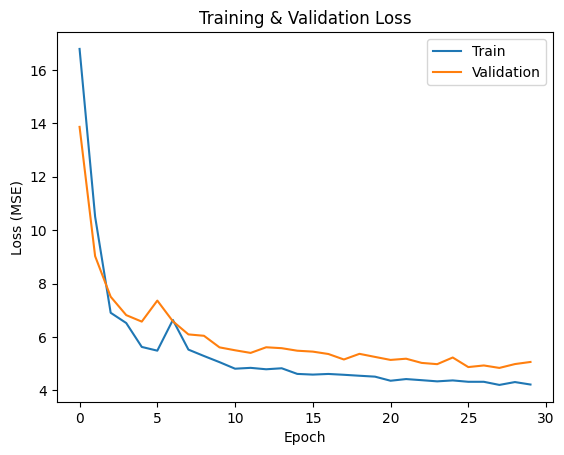

In [41]:
plt.plot(train_loss_history, label='Train')
plt.plot(val_loss_history, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()

In [42]:
from skimage.metrics import structural_similarity as ssim
import numpy as np
import torch

# --- pick one sample ---
test_idx = 3
final_mlem, true_image = test_dataset[test_idx]  # assuming tensors [H, W] or numpy

# ensure numpy arrays
true_image_np = true_image.numpy() if hasattr(true_image, "numpy") else true_image
final_mlem_np = final_mlem.numpy() if hasattr(final_mlem, "numpy") else final_mlem

# --- make a noisy sinogram and run MLEM (if you really need to re-generate) ---
sino_clean = radon(true_image_np, theta=theta, circle=True)
sino_noisy = add_poisson(sino_clean, 1e4)
mlem_im = mlem_reco(sino_noisy, theta, 5)  # -> [H, W] numpy

# --- run CNN refinement ---
model.eval()
with torch.no_grad():
    inp = torch.from_numpy(mlem_im).float().unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
    out = model(inp)                                    # [1,1,H,W]
    mlem_cnn = out.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]

# --- metrics ---
mse_mlem = np.mean((true_image_np - mlem_im)**2)
mse_cnn  = np.mean((true_image_np - mlem_cnn)**2)
ssim_mlem = ssim(true_image_np, mlem_im, data_range=true_image_np.max()-true_image_np.min())
ssim_cnn  = ssim(true_image_np, mlem_cnn, data_range=true_image_np.max()-true_image_np.min())

print(f"MSE  MLEM: {mse_mlem:.6f} | MLEM+CNN: {mse_cnn:.6f}")
print(f"SSIM MLEM: {ssim_mlem:.4f} | MLEM+CNN: {ssim_cnn:.4f}")


MSE  MLEM: 15.424126 | MLEM+CNN: 2.182074
SSIM MLEM: 0.4568 | MLEM+CNN: 0.9058


Text(0.5, 1.0, 'MLEM + CNN Reco \nMSE: 2.1821, SSIM: 0.9058')

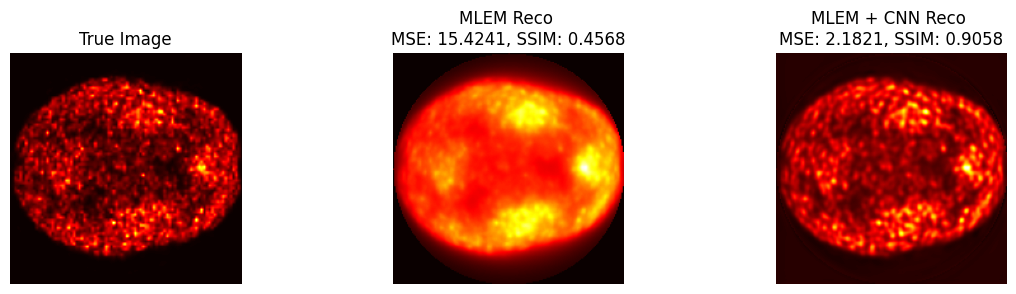

In [43]:
fig, axes = plt.subplots(1, 3, figsize=(14, 3))  # <- use fig and axes

#True Image
axes[0].imshow(true_image_np, cmap ="hot")
axes[0].axis("off")
axes[0].set_title("True Image")

#Denoised Image
axes[1].imshow(mlem_im, cmap="hot")
axes[1].axis("off")
axes[1].set_title(f'MLEM Reco \nMSE: {mse_mlem:.4f}, SSIM: {ssim_mlem:.4f}')

#Denoised Image
axes[2].imshow(mlem_cnn, cmap="hot")
axes[2].axis("off")
axes[2].set_title(f'MLEM + CNN Reco \nMSE: {mse_cnn:.4f}, SSIM: {ssim_cnn:.4f}')

In [46]:
from skimage.metrics import mean_squared_error

# Choose one test image for evaluation
test_idx = 2
mlem_np, true_image_np = test_dataset[test_idx]
mlem_np = mlem_np.numpy()
true_image_np = true_image_np.numpy()

sinogram_clean_np = radon(true_image_np, theta=theta, circle=True)

# Noise levels
max_counts = [1e2, 3e2, 5e2, 1e3, 5e3, 1e4]
relative_noise = [np.sqrt(c) / c for c in max_counts]
mse_scores_cnn = []
ssim_scores_cnn = []
mse_scores_mlem = []
ssim_scores_mlem = []
mse_scores_mlem15 = []
ssim_scores_mlem15 = []

model.eval()
num_its = 5

with torch.no_grad():
    for counts in max_counts:
        noisy_sino = add_poisson(sinogram_clean_np, max_counts=counts)
        
        # --- MLEM ---
        recon_mlem = mlem_reco(noisy_sino, theta, num_its)
        mse_mlem = mean_squared_error(true_image_np, recon_mlem)
        ssim_mlem = ssim(true_image_np, recon_mlem, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_mlem.append(mse_mlem)
        ssim_scores_mlem.append(ssim_mlem)

        # --- MLEM + CNN ---
        inp = torch.from_numpy(recon_mlem).float().unsqueeze(0).unsqueeze(0).to(device)  # [1,1,H,W]
        out = model(inp)                                    # [1,1,H,W]
        mlem_cnn = out.squeeze(0).squeeze(0).cpu().numpy()  # [H, W]
       
        mse = mean_squared_error(true_image_np, mlem_cnn)
        ssim_val = ssim(true_image_np, mlem_cnn, data_range=true_image_np.max() - true_image_np.min())
        mse_scores_cnn.append(mse)
        ssim_scores_cnn.append(ssim_val)

/scratch/bggjem001/opengate_env/lib/python3.9/site-packages/skimage/transform/radon_transform.py:74: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn(


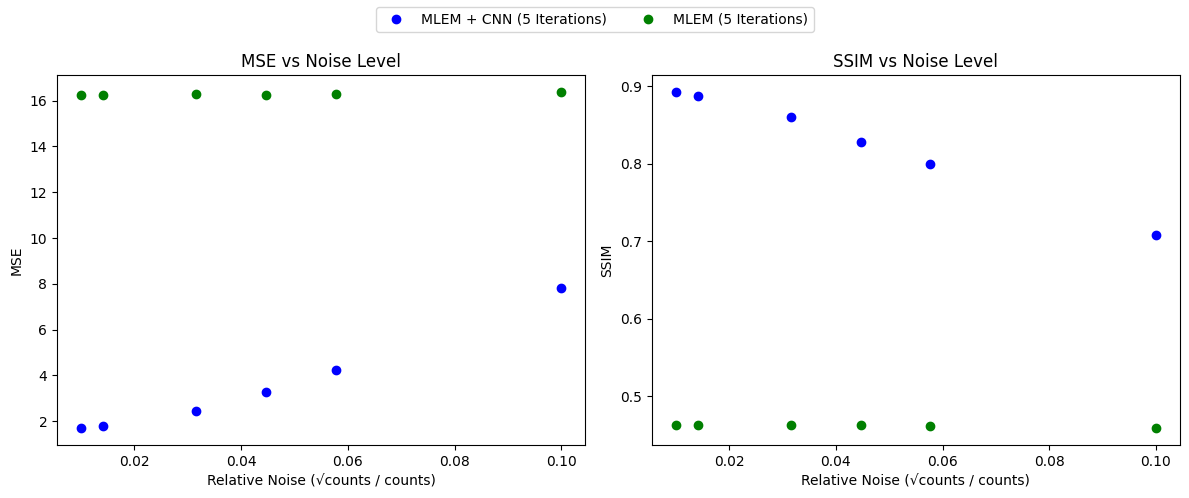

In [47]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # <- use fig and axes

# MSE plot
axes[0].plot(relative_noise, mse_scores_cnn, 'bo', label=f'MLEM + CNN ({num_its} Iterations)')
axes[0].plot(relative_noise, mse_scores_mlem, 'go', label=f'MLEM ({num_its} Iterations)')
axes[0].set_xlabel('Relative Noise (√counts / counts)')
axes[0].set_ylabel('MSE')
axes[0].set_title('MSE vs Noise Level')

# SSIM plot
axes[1].plot(relative_noise, ssim_scores_cnn, 'bo', label=f'MLEM + CNN ({num_its} Iterations)')
axes[1].plot(relative_noise, ssim_scores_mlem, 'go', label=f'MLEM ({num_its} Iterations)')
axes[1].set_xlabel('Relative Noise (√counts / counts)')
axes[1].set_ylabel('SSIM')
axes[1].set_title('SSIM vs Noise Level')


# Unified legend above both plots
handles, labels = axes[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=2, fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.93])  # Leave room for the legend
plt.show()